## problems we need to fix before final project: (coment from TA)
### major issue right now: not enough data
- #####Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”
- ##### underfitting? (look at our accuracy vs k)

- ##### Identified NA values, but did not do anything to deal with them. For example, since so many NA values are within the numprob column, this column can be removed and thus all NA values will be gone as well (current code causes NA by coercion error).
    - fix: remove numprob column, filter out NA
    - fixed

- ##### Work is not reproducible (data is read from local directory as opposed to remote source).Did not use set.seed() when doing initial.split (this also causes non-reproducibility since it will make different splits each time).
    - fix: set a seed
    - fixed, set.seed(100)

- ##### Why set options(repr.matrix.max.rows = 6) for the first few tables when it's causing the data you're trying to display  to get cut off?
    - fix: row = 13
    - fixed

- #####  Proposal lacks justification for choice of predictors - a lot of these predictors boil down to population size and testing capacity.

    - We can remove some population predictors:number confirmed, number probable, number of deaths, total number, keep:date,percent recovered (split date)
    - fixed

- ##### This dataset requires more exploratory analysis to determine coverage over time for different provinces and the distribution of predictor statistics by province. If the difference in number probable, number of deaths, total number, and number confirmed is consistent between provinces, then perhaps it only makes sense to use one of these?
    -  we can do date v.s. percent recovered for the provinces, distribution of predictor statistics by province (idk how?). We might want to keep one of these population based predictors as suggested in addition to time and percent recovered (mabe use number of confirmed to show testing capability of healthcare system).
    - later

- ##### Be careful with the 'too little data to stratify error'. This means that one of the classes might have too few data points in each class to stratify. 
  -  see if this still shows up after we remove numprob column, is it still show up we remove Nunavut
  - not fixed !!! removing colomns and Nunauvut did not help, I think the only way to fix this is to use another dataset ot colomns other than % recovered?
  - (Mikayla) Fixed this problem by removing the territories (Nunavut, Yukon and Northwest Territories)

- ##### Need to explain insights from summary table. Now that you have calculated the means of each column, what can you derive from that? 
  -  I thought we did...? Mabe write a new paragraph for summary table (since now we only explained it with graph)
  - later
 
- ##### Writing: Note that you've significantly exceeded the word count. I recommend doing your best to adhere to the limit in the final report submission.
  -  Final work count is 2000, we should check Rubric before submission 
- ##### For choosing K, (Jason) asked to TA: He said that we need to start setting K as 2, and increase K by 1 until K = 5 to find the best fitted k. 

- ### We need to focus on the choosing K, summary and reference part this week!
- ##  Thanks for Linda's work!!!

# Predicting Canadian provinces based on COVID-19 data
### Group Members
Jason Ji (69217222), Mikayla Chau (29043288), Linda Zhang (95711800), Alireza Mohammadi (20700985)

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Intoduction


COVID-19 is an infectious disease caused by SARS-CoV-2 virus (Government of Canada). The first known case was identified in Wuhan, China, on December 12th 2019 (CDC Museum Covid-19 Timeline). The disease quickly spread worldwide, resulting in the COVID-19 pandemic. The common symptoms of COVID-19 include fever, cough, headache, loss of smell and taste(Government of Canada). Canada is also severely impacted by COVID-19. Although there are a number of available vaccines and treatments, there were nearly 4,300,000 infected people by the end of September, 2022 . Ontario has the highest total number of infected people, nearly 1,470,000, however, the total number of infected people in Nunavut is just 3531. (Government of Canada) Because the Yukon, Northwest Territories and Nunavut are the closest to the Arctic Circle, there are not as many people living there as other 10 provinces, which causes a huge difference in the number of the total infected people per province/territory.

In this project, we want to predict which Canadian province best describes a territorial health report which has the total number of confirmed COVID-19 cases in a particular month of the year. In order to do so we will investigate public health information gathered from different Canadian territories since the start of the pandemic. 

The dataset we work on in this project is taken from https://health-infobase.canada.ca/ (health info base of Government of Canada) based on data that provincial and territorial partners published on cases and deaths. This data contains daily information of COVID-19 cases from January 2020 until December 2021. There are 7 important properties we want to choose as our classifier:

1. province : Canada province/territory (P/T) from which the information was reported, containing names of 13 Canadian provinces and territories.
2. date : Date of recorded observation
3. numconf : Number of confirmed cases in each P/T (Canada= sum of all P/T)
4. numprob : Number of probable cases in each P/T (Canada= sum of all P/T)
5. numdeaths : Number of deaths in each P/T (Canada= sum of all P/T)
6. numtotal : Total number of cases, calculated by number of confirmed cases plus number of probable cases.
7. Percentrecover : Percentage of recovered cases, Calculated by the number of recovered cases for P/T divided by the total number of confirmed cases for that P/T [(numrecover/numtotal) * 100]

As of October 21, 2022, 9 am ET,Public Health Agency of Canada(PHAC) has received detailed case report data on 4,135,488 cases.



References:

Public Health Agency. “Government of Canada.” Canada.ca, Government of Canada, 18 Aug. 2022, https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html
“CDC Museum Covid-19 Timeline.” David J. Sencer CDC Museum: In Association with the Smithsonian Institution, Centers for Disease Control and Prevention, 16 Aug. 2022, https://www.cdc.gov/museum/timeline/covid19.html. 

### Preliminary Data Analysis

The data is mostly tidy, however there are many columns we do not need for our analysis. Tidying the data included taking out these unwanted columns, any unwanted rows (Canada and Repatriated Travellers), and changing some column names to make it more reader-friendly. First, we read the data into R (NOTE: This data is for January 31, 2020 to December 17, 2021).

In [2]:
covid <- read_csv("canada-covid-19.csv")
covid

Rows: 9762 Columns: 40
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): prname, prnameFR, percentrecover
dbl  (36): pruid, update, numconf, numprob, numdeaths, numtotal, numtested, ...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,⋯,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
<dbl>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
35,Ontario,Ontario,2020-01-31,NA,3,0,0,3,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
59,British Columbia,Colombie-Britannique,2020-01-31,NA,1,0,0,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
1,Canada,Canada,2020-01-31,NA,4,0,0,4,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
62,Nunavut,Nunavut,2021-12-17,1,676,NA,4,676,NA,⋯,0.00,0,0.00,0,0.00,0,0.00,0,0.00,0.00
99,Repatriated travellers,Voyageurs rapatriés,2021-12-17,NA,13,NA,0,13,NA,⋯,NA,0,NA,0,NA,0,NA,0,NA,NA
1,Canada,Canada,2021-12-17,NA,1866907,NA,30032,1866907,NA,⋯,0.72,39216,102.54,132,0.35,5602,14.65,19,0.05,10.85


Next, we tidy our data, keeping only the columns we will use for our model.

In [3]:
# filtered original data into containing parameters that are needed for training the model. Parameters: province, date, number of confirmed cases, percent of recovered cases
filtered_covid <- covid |> 
    mutate(province = prname) |>
    select(province, date, numconf, percentrecover)

# Further filtering to remove missing data and inappropriate data
removed_missing_covid <- filtered_covid |>
    filter(province != "Repatriated travellers") |>
    filter(province != "Canada", province != "Yukon", 
           province != "Northwest Territories", province != "Nunavut") |>
    filter(percentrecover != "NA")|>
    filter(percentrecover != "N/A")

# formatting the percent of recovered cases into numeric values and organize the data by grouping by province
organized_covid <- removed_missing_covid |>
    mutate(percentrecover = as.numeric(percentrecover)) |>
    mutate(province = as.factor(province)) |>
    group_by(province)

# splitting the date variable into year, month and day
# removing variable day because it is not useful enough to capture information such as provincial COVID policies that are adjusted on monthly bases
split_date_covid <- organized_covid |>
separate(col = date, into = c("year","month","day"), sep = "-")

tidy_covid <- split_date_covid|>
    select(- day)|>
    mutate(year = as.numeric(year))|>
    mutate(month = as.numeric(month))
    
tidy_covid

province,year,month,numconf,percentrecover
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
British Columbia,2020,3,725,25.66
Alberta,2020,3,486,5.56
Saskatchewan,2020,3,95,3.16
⋮,⋮,⋮,⋮,⋮
New Brunswick,2021,12,10313,86.40
Nova Scotia,2021,12,9202,91.94
Prince Edward Island,2021,12,475,84.21


Next, we split our data set into a training and testing set, ensuring our model will not be affected by the data we will test it with.

In [4]:
covid_split <- initial_split(tidy_covid, prop = 0.75, strata = province)
covid_train <- training(covid_split)
covid_test <- testing(covid_split)

covid_train
covid_test

province,year,month,numconf,percentrecover
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
British Columbia,2020,3,725,25.66
Manitoba,2020,3,11,2.78
Ontario,2020,3,858,0.93
⋮,⋮,⋮,⋮,⋮
Quebec,2021,12,478246,93.48
Newfoundland and Labrador,2021,12,2152,95.31
Nova Scotia,2021,12,9202,91.94


province,year,month,numconf,percentrecover
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Alberta,2020,3,486,5.56
Saskatchewan,2020,3,95,3.16
Quebec,2020,3,1629,0.12
⋮,⋮,⋮,⋮,⋮
Newfoundland and Labrador,2021,12,2106,97.20
New Brunswick,2021,12,10313,86.40
Prince Edward Island,2021,12,475,84.21


### Summary Tables

The below table documents the average, minimum, and maximum values of each column.

In [5]:
# obs_num_summary <- group_by(covid_train, province)%>%
#                             summarize( 
#                              min_conf = min(numconf, na.rm = TRUE),
#                              mean_conf = mean(numconf,na.rm = TRUE),
#                              most_conf = max(numconf, na.rm = TRUE),
#                              min_death = min(numdeaths, na.rm = TRUE),
#                              mean_death = mean(numdeaths,na.rm = TRUE),
#                              most_death = max(numdeaths, na.rm = TRUE),
#                              min_total = min(numtotal, na.rm = TRUE),
#                              mean_death = mean(numtotal,na.rm = TRUE),
#                              most_total = max(numtotal, na.rm = TRUE),
#                              )
# obs_num_summary

This table collects the number of observations for each province, ordering from most to least.

In [6]:
# province_obs <- group_by(covid_train,province)%>%
# summarize(num_obs=n()) |>
# arrange(by = desc(num_obs))
# province_obs

This table records how much missing data there is and in which columns they occur.

In [7]:
# missing <- covid_train %>% summarise_all(~ sum(is.na(.)))
# missing

### Visualization

Before we completed the visualization, we had to mutate the data slightly, finding the overall average recovery rate for each province.

In [8]:
# options(repr.plot.width = 10, repr.plot.height = 8)
# recover_table <- covid_train |> 
#     mutate(mean_percent = mean(percentrecover, na.rm = TRUE)) |>
#     select(province, mean_percent) |>
#     group_by(province) |>
#     summarize(mean_percent = mean(mean_percent)) |>
#     arrange(mean_percent)
# recover_table

For the visualization itself, we plotted the province name against the over average recovery rate. This visualization shows that there is a relationship between recovery rates and province (different provinces and territories have different recovery rates), demonstrating that we will be able to identify the province with the highest recovery rate, whether overall, month-by-month, or even day-by-day.

In [9]:
# recover_plot <- recover_table |>
# ggplot(aes(x = fct_reorder(province, mean_percent, .desc = TRUE), y = mean_percent)) +
#         geom_bar(stat = "identity")+
#         labs(x = "Province", y = "Average Percent Recovered", fill = "Province")+
#         theme(text = element_text(size = 20))+
#         coord_flip()+
#     ggtitle("Relationship between Average \nPercent Recovered and Province")
# recover_plot

### Methods

For our data analysis, we will split the COVID-19 data (dating from January 31, 2020, to December 17, 2021) into a testing and training set. Next, we will use the date, number confirmed, number probable, number of deaths, total number, and percent recovered to train our data to predict which province the data is describing. 

As stated in the introduction, difference in provice/territory population means that the number of people who recover does not carry the same weight between provinces. Therefore, we use percent recovered to account for this variation.

In addition to the data of the total number of confirmed cases, there are other variables which are different for 13 provinces in Canada and we can use them as our classifiers. Such as, number of probable cases,  number of deaths and percentage of recovery cases.

At the end of the project, we will visualize our results through a scatter plot, plotting the number of confirmed cases against date, then colouring the data points according to province.

### Expected Outcomes and Significance

For this project, we will be building a Knn classification model that predicts province name based on date, number of confirmed cases, number of probable cases, number of deaths, total number of cases and  percentage of recovered cases. We believe that these predictors (except for date) are a unique feature of each province which is a result of its province demographics, COVID policies and medical system. For example, in our visualization, Prince Edward Island and Newfoundland and Labrador have the same highest recovery rate. We believe that the Maritime provinces (Nova Scotia, Newfoundland and Labrador, PEI, New Brunswick) will have the highest COVID-19 recovery rates because They have a smaller population and likely have a healthcare system that will not be overwhelmed by COVID-19 cases.

At the initial stage of proposing our project, from the relationship between average percent recovered and province, we can observe a difference in recovery rate that varies across provinces. This made us wonder what is contributing to this difference? Province demographics, COVID policies and medical system can all lead to the kind of differences between provinces that is displayed in a relationship like recovery rate. More specifically, population density, mask mandate and tester kit provision could contribute to the number of confirmed cases, probable cases and total number of cases in a particular province. Number of deaths, for example, would increase if the demographic of the population appears to be more aged. The efficiency and capacity of the medical system on the other hand can lead to differences in average percent recovered across provinces. We could gain a grasp of whether or not our speculation of “characteristic of province effect covid conditions of that province” is correct if we can make accurate predictions (classify) a province based on covid conditions variables: number of confirmed cases,number of probable cases, number of deaths, total number of cases and  percentage of recovered cases. Our study can allow us to gain a grasp on whether or not the COVID situation in each province is uniquely related to its various demographical, political and infrastructural features that can help future studies to extend on which area to focus more when handling COVID-19 and identify the provinces that need more support or response strategies.


Future questions:

1. Why does Prince Edward Island and Newfoundland and Labrador have the highest recovery rate? (derive a casual relationship)
2. Does the recovery rate relate to other categorical variables that show a considerable difference between the province with highest recovery rate and others? 
3. Can the successes of such two provinces be adapted to help improve the recovery rates of other provinces given that demographic and medical system differences exist between different provinces?
4. How can we make a decision about what percent of weight does every predictor account for?


### data analysis

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8870873,5,0.006476456,Preprocessor1_Model01
2,accuracy,multiclass,0.8870873,5,0.006476456,Preprocessor1_Model02
3,accuracy,multiclass,0.8494547,5,0.006939875,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,multiclass,0.7978375,5,0.008472713,Preprocessor1_Model08
9,accuracy,multiclass,0.7812797,5,0.009294578,Preprocessor1_Model09
10,accuracy,multiclass,0.7761180,5,0.009084116,Preprocessor1_Model10


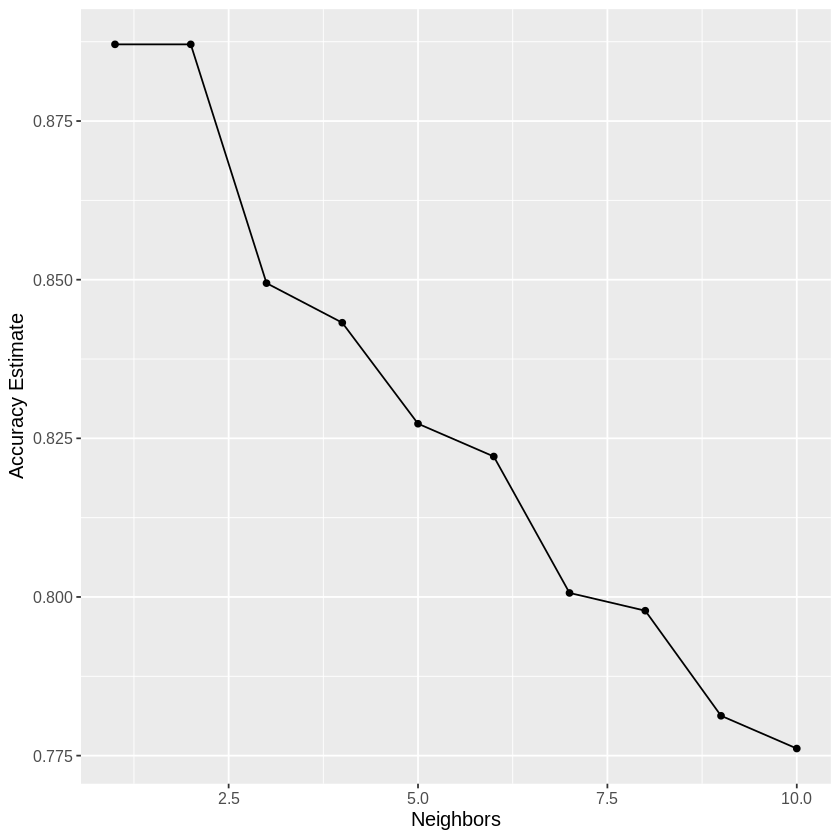

In [10]:
# Preforming 5 fold cross validation to find the best value for k
covid_train_vfold <- vfold_cv(covid_train, v= 5, strata= province)

# Model specification
knn_spec <- nearest_neighbor(weight_func= "rectangular", neighbors= tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Recipe for setting province as target variable and all others as predictors;
# Then standardize the predictors
covid_recipe <- recipe(province ~ ., data= covid_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Evaluate the model for 10 values of k
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_fit <- workflow() |>
    add_recipe(covid_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples= covid_train_vfold, grid= k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
knn_fit

# Plot mean accuracy for values of k
accuracy_vs_k <- ggplot(knn_fit, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

I think we would be good with just k = 2 since our data is already in a "line plot" so it makes sense that our model is more inaccurate with the more neighbours we choose (in previous worksheets, we were analyzing data that was more scattered which is why the number of neighbours was larger).

In [11]:
# Choosing the best k based on accuracy plot
best_k <- 2

# Model specification
covid_spec <- nearest_neighbor(weight_func= "rectangular", neighbors= best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

# Combine model specification and recipe in a workflow and build the classifier
covid_fit <- workflow() |>
    add_recipe(covid_recipe) |>
    add_model(covid_spec) |>
    fit(data= covid_train)

# Predict province using test data
class_prediction <- covid_fit |>
    predict(covid_test) |>
    bind_cols(covid_test)
class_prediction

# Compute the accuracy 
classifier_accuracy <- class_prediction |>
    metrics(truth= province, estimate= .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate)
classifier_accuracy

# Confusion matrix
confusion_matrix <- class_prediction |>
    conf_mat(truth= province, estimate= .pred_class)
confusion_matrix

.pred_class,province,year,month,numconf,percentrecover
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Alberta,Alberta,2020,3,486,5.56
Nova Scotia,Saskatchewan,2020,3,95,3.16
Ontario,Quebec,2020,3,1629,0.12
⋮,⋮,⋮,⋮,⋮,⋮
Newfoundland and Labrador,Newfoundland and Labrador,2021,12,2106,97.20
New Brunswick,New Brunswick,2021,12,10313,86.40
New Brunswick,Prince Edward Island,2021,12,475,84.21


.estimate
<dbl>
0.9083871


                           Truth
Prediction                  Alberta British Columbia Manitoba New Brunswick
  Alberta                       142                0        0             0
  British Columbia                3              135        2             0
  Manitoba                        0                1      128             3
  New Brunswick                   0                0        0           151
  Newfoundland and Labrador       0                0        0            11
  Nova Scotia                     3                1        3            10
  Ontario                         1                0        0             0
  Prince Edward Island            0                0        3             8
  Quebec                          0                0        1             0
  Saskatchewan                    0                3        7             5
                           Truth
Prediction                  Newfoundland and Labrador Nova Scotia Ontario
  Alberta               